In [1]:
from sklearn.decomposition import IncrementalPCA, PCA

from PIL import Image
from skimage.metrics import structural_similarity as ssim

import numpy as np
from matplotlib import pyplot as plt

import time
import warnings

from typing import Callable, Union, Literal

In [2]:
def time_counter(log_iters: int = 1):
    def wrapper(func: Callable):
        def get_time(*args, **kwargs):
            tic = time.perf_counter()
            res = func(*args, **kwargs)
            toc = time.perf_counter()
            if get_time.num_runs % log_iters == 0:
                print(f"Time spent for current {func.__name__} iteration is {toc - tic:0.4f} seconds.")
                print(f"Function {func.__name__} was already called {get_time.num_runs} times.")
            get_time.num_runs += 1
            return res, toc - tic
        get_time.num_runs = 0
        return get_time
    return wrapper

@time_counter(50)
def fit_transform_PCA(model: PCA, data: np.ndarray):
    model.fit(data)
    transformed = model.transform(data)
    
    return transformed

@time_counter(50)
def inverse_transform_PCA(model: PCA, transformed: np.ndarray):
    inverse = model.inverse_transform(transformed)
    return inverse

@time_counter(50)
def fit_transform_whole_IPCA(model: IncrementalPCA, data: np.ndarray, num_blocks: int):
    whole_transformed = None
    for i in range(len(data) // num_blocks):
        batch = data[num_blocks * i: num_blocks * (i + 1)]
        model.partial_fit(batch)
        transform_batch = model.transform(arr)
        if whole_transformed is None:
            whole_transformed = transform_batch
        else:
            whole_transformed = np.concatenate([whole_transformed, transform_batch], axis=0)
    
    return whole_transformed
        
@time_counter(50)
def inverse_transform_whole_IPCA(model: IncrementalPCA, transformed: np.ndarray, num_blocks: int):
    whole_inverse = None
    for i in range(len(transformed) // num_blocks):
        batch = transformed[num_blocks * i: num_blocks * (i + 1)]
        inv_batch = model.inverse_transform(batch)
        if whole_inverse is None:
            whole_inverse = inv_batch
        else:
            whole_inverse = np.concatenate([whole_inverse, inv_batch], axis=0)
        if i % 10:
            print(f'Inverse on {i}-th iteration')
    
    return whole_inverse

In [3]:
def benchmark_model_on_image(model_name: Literal['IPCA', 'PCA'], image: np.ndarray):
    ssim_arr = []

    transform_times = []
    inverse_times = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
       
        for num_components in range(1, min(image.shape[:2])):
            if model_name == 'PCA':
                model = PCA(n_components=num_components)
                transformed, transform_time = fit_transform_PCA(model, image)
                inverse, inverse_time = inverse_transform_PCA(model, transformed)
            else:
                model = IncrementalPCA(n_components=num_components)
                transformed, transform_time = fit_transform_whole_IPCA(model, image, num_blocks=num_components)
                print(len(transformed))
#                 inverse, inverse_time = inverse_transform_whole_IPCA(model, transformed, num_blocks=num_components)
            
            transform_times.append(transform_time)
            inverse_times.append(inverse_time)
            
            ssim_n = ssim(image, inverse, data_range=inverse.max() - inverse.min())
            ssim_arr.append(ssim_n)
            
            if ssim_n > 0.9:
                break
            
    return ssim_arr, transform_times, inverse_times

In [8]:
ssim_arr, transform_times, inverse_times = benchmark_model_on_image('PCA', arr)

Time spent for current fit_transform_PCA iteration is 0.0545 seconds.
Function fit_transform_PCA was already called 0 times.
Time spent for current inverse_transform_PCA iteration is 0.0069 seconds.
Function inverse_transform_PCA was already called 0 times.
Time spent for current fit_transform_PCA iteration is 0.0453 seconds.
Function fit_transform_PCA was already called 50 times.
Time spent for current inverse_transform_PCA iteration is 0.0041 seconds.
Function inverse_transform_PCA was already called 50 times.
Time spent for current fit_transform_PCA iteration is 0.0840 seconds.
Function fit_transform_PCA was already called 100 times.
Time spent for current inverse_transform_PCA iteration is 0.0063 seconds.
Function inverse_transform_PCA was already called 100 times.


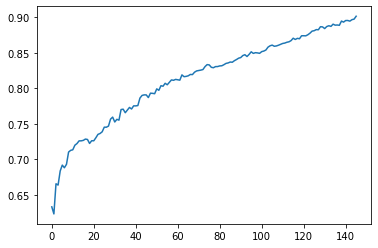

In [10]:
plt.plot(ssim_arr)

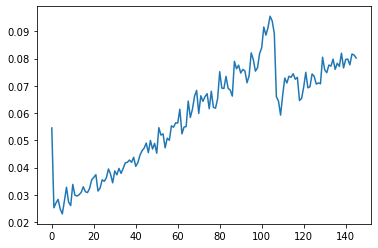

In [13]:
plt.plot(transform_times)

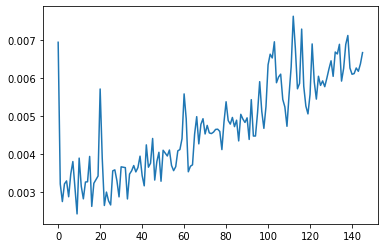

In [15]:
plt.plot(inverse_times)

In [ ]:
ssim_arr, transform_times, inverse_times = benchmark_model_on_image('IPCA', arr)

In [4]:
img = Image.open('1632441447737.png').convert('L')

In [5]:
arr = np.array(img)

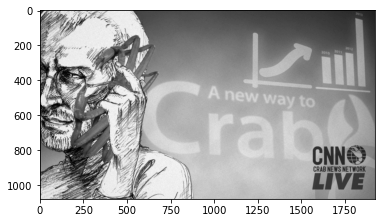

In [6]:
plt.imshow(arr, cmap='gray')

In [5]:
pca = IncrementalPCA()
pca.fit(arr)
transformed = pca.transform(arr)

/home/ippk93/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/ippk93/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


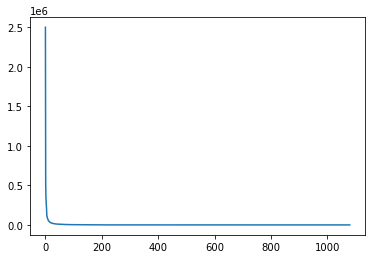

In [6]:
plt.plot(pca.explained_variance_)

In [7]:
n_comps = 10
pca = IncrementalPCA(n_components=n_comps)

In [8]:
for i in range(len(arr) // n_comps):
    batch = arr[n_comps * i: n_comps * (i + 1)]
    pca.partial_fit(batch)

/home/ippk93/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/ippk93/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
arr_ = pca.transform(arr)

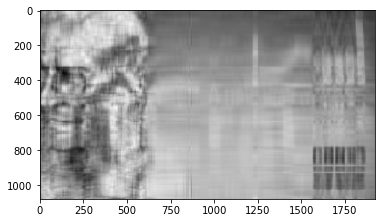

In [10]:
plt.imshow(pca.inverse_transform(arr_), cmap='gray')

In [11]:
pca = PCA(n_components=n_comps)
img_transformed = pca.fit_transform(arr)

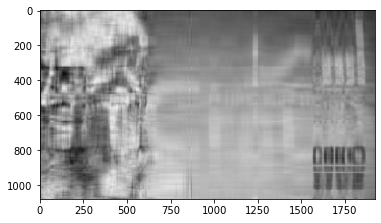

In [12]:
plt.imshow(pca.inverse_transform(img_transformed), cmap='gray')

In [15]:
plt.imshow(pca.inverse_transform(pca_cp), cmap='gray')

NameError: name 'pca_cp' is not defined

In [14]:
pca_ = PCA(n_components=10)
pca_cp_ = pca_.fit_transform(arr)

In [ ]:
plt.imshow(pca_.inverse_transform(pca_cp_), cmap='gray')

In [ ]:
lim = 1080
ssim_arr = []
for n in range(lim):
    pca = PCA(n_components=n)
    pca.fit(arr)
    transform = pca.transform(arr)
    arr_trans = pca.inverse_transform(transform)
    ssim_n = ssim(arr, arr_trans, data_range=arr_trans.max() - arr_trans.min())
    ssim_arr.append(ssim_n)

In [ ]:
plt.plot(ssim_arr)

In [ ]:


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    issim_arr = []
    issim_n = 0.
    ni = 1
    while(issim_n < 0.9):
        ipca = IncrementalPCA(n_components=ni)
        for i in range(len(arr) // ni):
            batch = arr[ni * i: ni * (i + 1)]
            ipca.partial_fit(batch)
        transform = ipca.transform(arr)
        arr_trans = ipca.inverse_transform(transform)
        issim_n = ssim(arr, arr_trans, data_range=arr_trans.max() - arr_trans.min())
        issim_arr.append(issim_n)
        ni += 1